In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchvision
import torchvision.datasets as datasets
import sys
import numpy as np
import torch.utils.data as utils
from torch.utils.data import DataLoader
from sklearn.metrics import auc,average_precision_score, roc_curve,roc_auc_score,precision_recall_curve, f1_score
from torch.utils.data import Subset
from torchvision import  transforms
import pickle as pkl
from os.path import join as oj
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim import lr_scheduler
import os
import argparse
from torch import nn
from numpy.random import randint
import torchvision.models as models
import time
import copy
from tqdm import tqdm
sys.path.append('../code/')
import cd
import sys
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
from copy import deepcopy
import pandas as pd
import seaborn as sns
sns.set()
import torch.nn.functional as F
from os.path import join as oj
pd.set_option('precision', 2)
%matplotlib inline

In [3]:
save_path = "../results_for_export"
trained_model_folder = '../models/ISIC/feature_models/'
fnames = sorted([oj(trained_model_folder, fname) for fname in os.listdir(trained_model_folder) if 'pkl'  in fname]) 
# other models were trained badly

results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in (fnames)] 
results = pd.concat(results_list, axis=1).T.infer_objects() 


/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


In [4]:
results['final_acc'] = [max(x) for x in results['val_acc_history']] #TODO change so it 
results['final_acc_train'] = [max(x)  for x in results['train_acc_history']]
results['AUC (no patches)'] =[0 for x in results['regularizer_rate']]
results['final_cd'] = [min(x) for x in results['train_cd_history']]
results['final_test_loss'] = [min(x) for x in results['val_loss_history']]
results['final_train_loss'] = [min(x) for x in results['train_loss_history']]
results['F1 score (no patches)'] =[0 for x in results['regularizer_rate']]
results['F1 score (patches)'] =[0 for x in results['regularizer_rate']]
results['AUC (patches)'] =[0 for x in results['regularizer_rate']]
results = results[results.regularizer_rate <100]

In [31]:
results[['regularizer_rate',
                       'final_acc', 
                       'AUC (no patches)',
                       'F1 score (no patches)',
                       'AUC (patches)',
                       'F1 score (patches)']].groupby(['regularizer_rate',]).mean()

,final_acc,AUC (no patches),F1 score (no patches),AUC (patches),F1 score (patches)
regularizer_rate,,,,,
-1.0,0.8855,0.8618,0.5851,0.9060,0.5746
0.0,0.8370,0.8538,0.5793,0.9231,0.5793
1.0,0.9030,0.8603,0.5942,0.9266,0.5942
10.0,0.9121,0.8716,0.6162,0.9325,0.6162
30.0,0.8791,0.8712,0.6125,0.9323,0.6125


In [33]:
results[['regularizer_rate',
                       'final_acc', 
                       'AUC (no patches)',
                       'F1 score (no patches)',
                       'AUC (patches)',
                       'F1 score (patches)']].groupby(['regularizer_rate',]).std()

,final_acc,AUC (no patches),F1 score (no patches),AUC (patches),F1 score (patches)
regularizer_rate,,,,,
-1.0,0.0150,0.0005,0.0002,0.0065,0.0051
0.0,0.0345,0.0079,0.0166,0.0041,0.0166
1.0,0.0032,0.0121,0.0281,0.0065,0.0281
10.0,0.0025,0.0042,0.0173,0.0022,0.0173
30.0,0.0422,0.0058,0.0174,0.0030,0.0174


# Calculate ROC AUC

In [8]:
data_path = "../../../datasets"
save_path = oj(data_path, "ISIC_features")
from torch.utils.data import TensorDataset, ConcatDataset
with open(oj(save_path, "cancer.npy"), 'rb') as f:
    cancer_featuress = np.load(f)
with open(oj(save_path, "not_cancer.npy"), 'rb') as f:
    not_cancer_featuress = np.load(f)
    
cancer_targets = np.ones((cancer_featuress.shape[0])).astype(np.int64)
not_cancer_targets = np.zeros((not_cancer_featuress.shape[0])).astype(np.int64)
with open(oj(save_path, "not_cancer_cd.npy"), 'rb') as f:
    not_cancer_cd= np.load(f)
not_cancer_dataset = TensorDataset(torch.from_numpy(not_cancer_featuress).float(), torch.from_numpy(not_cancer_targets),torch.from_numpy(not_cancer_cd).float())

cancer_dataset = TensorDataset(torch.from_numpy(cancer_featuress).float(), torch.from_numpy(cancer_targets),torch.from_numpy(-np.ones((len(cancer_featuress), 2, 25088))).float())
complete_dataset = ConcatDataset((cancer_dataset, not_cancer_dataset))



num_total = len(complete_dataset)
num_train = int(0.8 * num_total)
num_val = int(0.1 * num_total)
num_test = num_total - num_train - num_val
torch.manual_seed(0);
train_dataset, test_dataset, val_dataset= torch.utils.data.random_split(complete_dataset, [num_train, num_test, num_val])


datasets = {'train' : train_dataset, 'test':test_dataset, 'val': val_dataset}
dataset_sizes = {'train' : len(train_dataset), 'test':len(test_dataset), 'val': len(val_dataset)}

In [9]:
test_filtered_dataset = torch.utils.data.Subset(complete_dataset, [idx for idx in test_dataset.indices if complete_dataset[idx][2][0,0] ==-1])

In [10]:
device = torch.device(0)
long_model = models.vgg16(pretrained=True)
# make conv untrainable - test if needed
long_model.classifier[-1] = nn.Linear(4096, 2)
long_model = long_model.to(device)
model = long_model.classifier

In [11]:
def eval_model_on(model, dataset):
    val_filtered_dataloader = torch.utils.data.DataLoader(dataset, batch_size=16,
                                             shuffle=True, num_workers=4)
    model.eval()
    y = []
    y_hat = []
    softmax= torch.nn.Softmax()
    with torch.no_grad() :
        for inputs, labels, cd in val_filtered_dataloader:
            y_hat.append((labels).cpu().numpy())
            y.append(torch.nn.Softmax(dim=1)( model(inputs.cuda()))[:,0].detach().cpu().numpy())
    y_hat = np.concatenate( y_hat, axis=0 )
    y = np.concatenate( y, axis=0 )
    return 1-y, y_hat


In [12]:
results_for_auc = results[['regularizer_rate','pid',]]

f1_scores_pid = {}

auc_scorespid = {}

for index, row in results_for_auc.iterrows():

    with open(oj(trained_model_folder, str(row['pid']) + '.pt'), 'rb') as f:

        weights = torch.load(f)
    model.load_state_dict(weights)
#     model = long_model.classifier
    y, y_hat = eval_model_on(model, test_filtered_dataset)
    auc_scorespid[row['pid']] = roc_auc_score(y_hat, y)
    f1_scores_pid[row['pid']] = np.asarray([f1_score(y_hat, y > x) for x in np.linspace(0.1,1, num = 20) ]).max()

results['AUC (no patches)'] =[auc_scorespid[x] for x in results['pid']]
results['F1 score (no patches)'] =[f1_scores_pid[x] for x in results['pid']]

/home/lauri/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lauri/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lauri/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lauri/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lauri/.local/lib/python3.6/site-packages/sklearn/metrics/classificatio

In [13]:
results_for_auc = results[['regularizer_rate','pid',]]
f1_scores_pid = {}
auc_scorespid = {}

for index, row in results_for_auc.iterrows():

    with open(oj(trained_model_folder, str(row['pid']) + '.pt'), 'rb') as f:
        weights = torch.load(f)
    model.load_state_dict(weights)

    y, y_hat = eval_model_on(model, test_dataset)
    auc_scorespid[row['pid']] = roc_auc_score(y_hat, y)
    f1_scores_pid[row['pid']] = np.asarray([f1_score(y_hat, y > x) for x in np.linspace(0.1,1, num = 20) ]).max()

results['AUC (patches)'] =[auc_scorespid[x] for x in results['pid']]
results['F1 score (patches)'] =[f1_scores_pid[x] for x in results['pid']]

/home/lauri/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lauri/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lauri/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lauri/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lauri/.local/lib/python3.6/site-packages/sklearn/metrics/classificatio

# Find failures

In [14]:

import torchvision.models as models
from PIL import Image
device = torch.device("cuda")
model_no_reg = models.vgg16(pretrained=True)
model_no_reg.classifier[-1] = nn.Linear(4096, 2)
model_no_reg = model_no_reg.eval()
model_no_reg.classifier.load_state_dict(torch.load('../models/ISIC/feature_models/03003534103033476204.pt'));
model_reg = models.vgg16(pretrained=True)
model_reg.classifier[-1] = nn.Linear(4096, 2)
model_reg = model_reg.eval()
model_reg.classifier.load_state_dict(torch.load('../models/ISIC/feature_models/35353744220131105427.pt'));
model_no_reg = model_no_reg.cuda()
model_reg = model_reg.cuda()

In [15]:
# load the two imgs
data_path = "../../../datasets/ISIC/raw_data/"
img_path_nocancer = oj(data_path, "not_cancer")
img_path_cancer = oj(data_path, "cancer")
seg_path  = oj(data_path, "../segmentation")
mean = np.asarray([0.485, 0.456, 0.406])
std = np.asarray([0.229, 0.224, 0.225])

In [16]:
from torchvision.transforms import ToTensor, Compose, Normalize
complete_dataset = torchvision.datasets.ImageFolder(data_path, transform=Compose([ToTensor(), Normalize(mean, std)]))
num_total = len(complete_dataset)
num_train = int(0.8 * num_total)
num_val = int(0.1 * num_total)
num_test = num_total - num_train - num_val
torch.manual_seed(0);
train_dataset, test_dataset, val_dataset= torch.utils.data.random_split(complete_dataset, [num_train, num_test, num_val])
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16,
                                             shuffle=False, num_workers=4)

In [17]:
with torch.no_grad():
    correct = 0
    correct_noreg = 0
    my_list = []
    my_list_targets = []

    for inputs, target in val_dataloader:

        inputs = inputs.to(device)
        target = 1- target.to(device) #switched classes for the dataset
        out_reg = model_reg(inputs)
        out_noreg = model_no_reg(inputs)
        correct+= (out_reg.argmax(dim = 1) == target).sum().item()
        correct_noreg+= (out_noreg.argmax(dim = 1) == target).sum().item()
        example_idx = np.where(((out_reg.argmax(dim = 1) == target)*(out_noreg.argmax(dim = 1) != target)).cpu().numpy())[0]
        
        if len(example_idx) >0:
            for idx in example_idx:

                my_list.append(inputs[idx])
                my_list_targets.append(target[idx].item())

## GradCAM on images

In [18]:
sys.path.append("../../pytorch-cnn-visualizations/src")
from vanilla_backprop import VanillaBackprop
from smooth_grad import generate_smooth_grad
from tqdm import tqdm_notebook
from gradcam import GradCam
from integrated_gradients import IntegratedGradients
sys.path.append("../../pytorch-cnn-visualizations")
from gradcam import GradCam
import gradcam
from misc_functions import get_example_params
import torchvision.models as models
from PIL import Image


In [36]:

model_no_reg = models.vgg16(pretrained=True)
model_no_reg.classifier[-1] = nn.Linear(4096, 2)
model_no_reg = model_no_reg.eval()
model_no_reg.classifier.load_state_dict(torch.load('../models/ISIC/feature_models/03003534103033476204.pt'));
model_reg = models.vgg16(pretrained=True)
model_reg.classifier[-1] = nn.Linear(4096, 2)
model_reg = model_reg.eval()
model_reg.classifier.load_state_dict(torch.load('../models/ISIC/feature_models/35353744220131105427.pt'));

In [37]:
my_list_all = [val_dataset[i+20][0] for i in range(100) ]
my_list_targets_all = [1-val_dataset[i+20][1] for i in range(100) ]

In [38]:
model_reg = model_reg.cuda()
model_no_reg = model_no_reg.cuda()

grad_cam_noreg = GradCam(model_no_reg, target_layer=29)
grad_cam_reg = GradCam(model_reg, target_layer=29)

In [39]:
triples = []
for img, target in tqdm_notebook(zip(my_list_all[:100], my_list_targets_all[:100])):
    img.requires_grad= True
    test_img = img.cuda()
    test_img = test_img[None, :, :224, :224]
    img_np = img[:, :224, :224].detach().cpu().numpy().transpose(1,2,0)*std[None, None, :] + mean[None, None, :]
    reg_saliency = grad_cam_reg.generate_cam(test_img, target)
    vanilla_saliency = grad_cam_noreg.generate_cam(test_img, target)
    triples.append((img_np, vanilla_saliency, reg_saliency, target))

In [40]:
save_path = "../results_for_export"

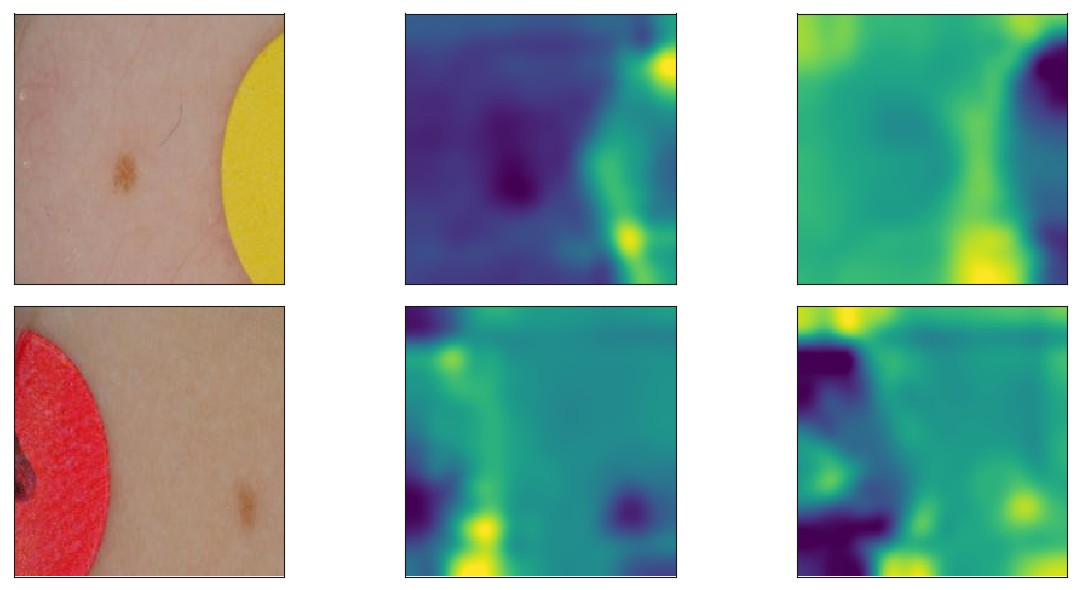

In [48]:

sns.reset_orig()
idxs = [1,9]
num_rows = len(idxs)

fig, axes = plt.subplots(num_rows,3, figsize=  (4.2*3, num_rows*3))


# axes[0,0].set_title( "Image")
# axes[0,1].set_title( "Vanilla")
# axes[0,2].set_title( "CDEP")
for i, (idx) in enumerate(idxs):
    original_img, vanilla_sal, reg_sal, true_class = triples[idx]

    axes[i,0].imshow(np.clip(original_img,0,1))
    axes[i,0].tick_params(axis='both', which='both', bottom=False, left = False, top=False, labelbottom=False, labelleft = False)

    axes[i,1].imshow( vanilla_sal, cmap = plt.get_cmap("viridis"),)
    axes[i,1].tick_params(axis='both', which='both', bottom=False, left = False, top=False, labelbottom=False, labelleft = False)
    axes[i,2].imshow(reg_sal, cmap =plt.get_cmap("viridis"))
#     pcm = axes[i,2].imshow(reg_sal, cmap =plt.get_cmap("viridis"))
#     pcm = axes[i,2].imshow(np.random.normal(size =(20,20)),
#                             cmap=plt.get_cmap("viridis"))
    axes[i,2].tick_params(axis='both', which='both', bottom=False, left = False, top=False, labelbottom=False, labelleft = False)
#     if i ==1:
#         fig.colorbar(pcm, ax=axes[i,2])
plt.tight_layout()

fig.savefig(oj(save_path,"gradCAM"))

In [90]:
cancer_triples = [x for x in triples if x[3] ==1]

In [91]:
no_cancer_triples = [x for x in triples if x[3] ==0]

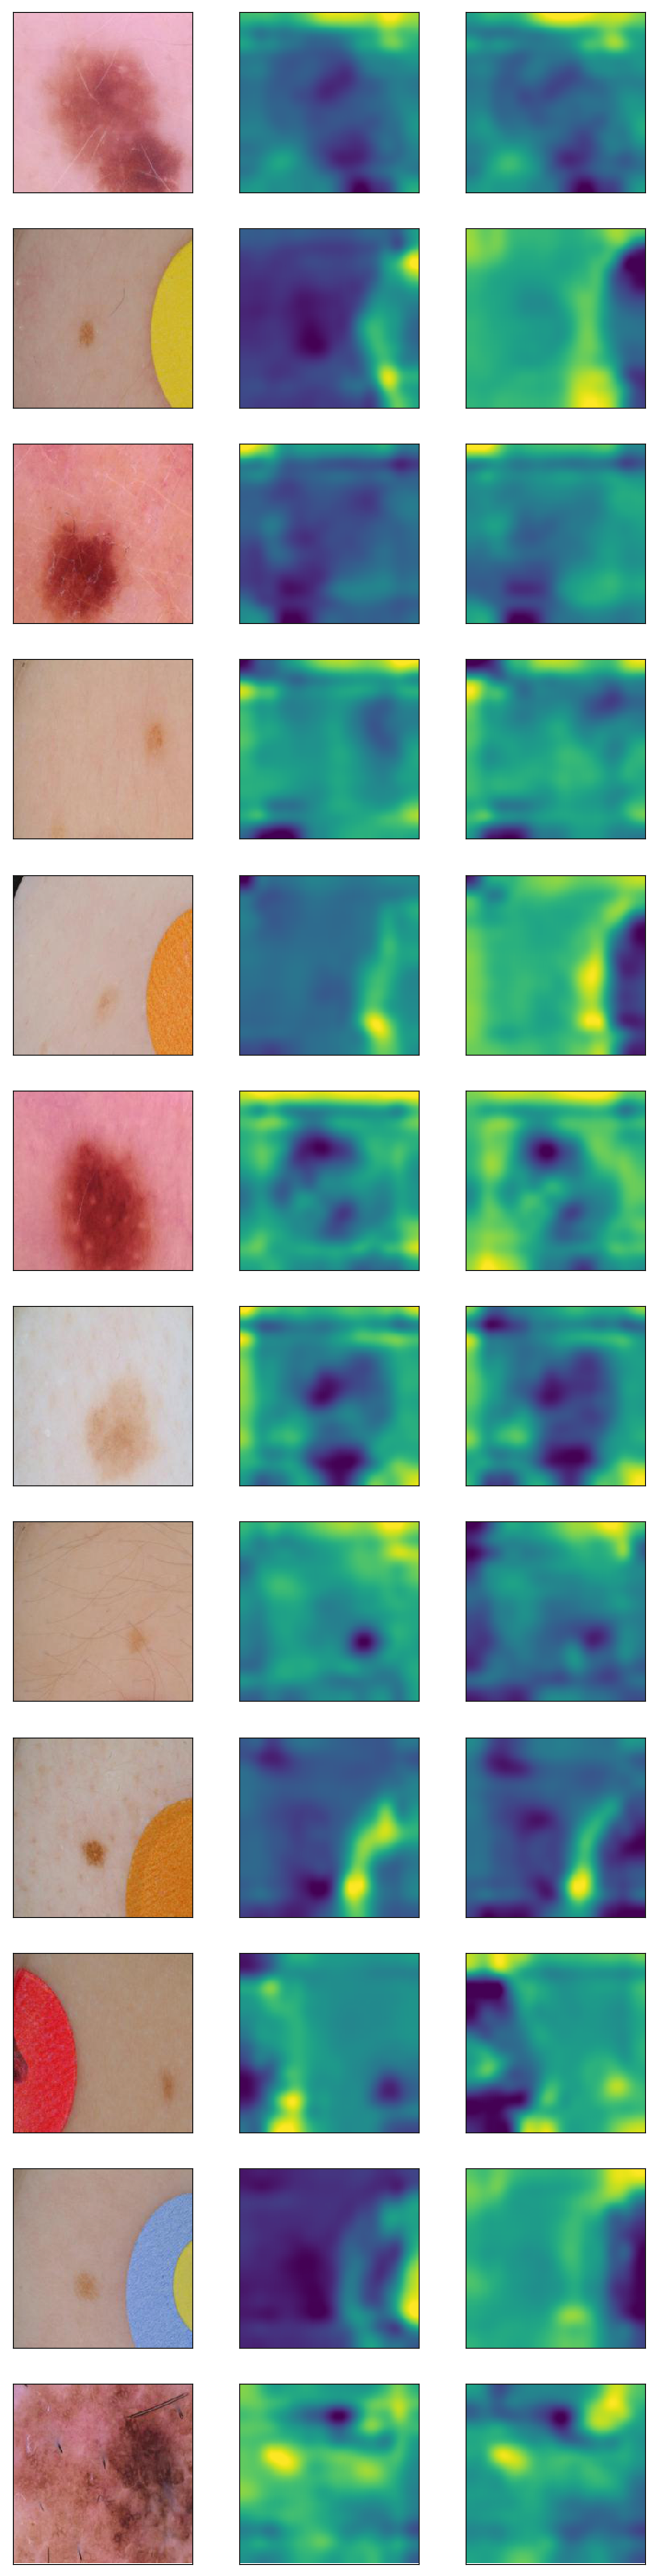

In [93]:
sns.reset_orig()
num_rows = len(cancer_triples)
fig, axes = plt.subplots(ncols=3, nrows = num_rows, figsize=  (3*3, num_rows*3))
i_small  =0 
for i, (original_img, vanilla_sal, reg_sal, true_class) in enumerate(no_cancer_triples[:num_rows]):



    axes[i,0].imshow(np.clip(original_img,0,1))
    axes[i,0].tick_params(axis='both', which='both', bottom=False, left = False, top=False, labelbottom=False, labelleft = False)

    axes[i,1].imshow(vanilla_sal)
    axes[i,1].tick_params(axis='both', which='both', bottom=False, left = False, top=False, labelbottom=False, labelleft = False)

    axes[i,2].imshow(reg_sal)
    axes[i,2].tick_params(axis='both', which='both', bottom=False, left = False, top=False, labelbottom=False, labelleft = False)
